In [7]:
import numpy as np 


def improved_gaussian_for_video(n=8):
    """Phương pháp gaussian+ cải tiến cho video classification"""
    temperature=5.0
    indices = np.arange(30)
    # Đặt đỉnh Gaussian gần đầu video hơn (1/6 chiều dài video)
    mean_index = 30 / 6
    
    # Điều chỉnh độ rộng dựa trên temperature
    std_dev = 30 / (20 / temperature)
    
    # Tính logits với Gaussian lệch về đầu
    logits = np.exp(-((indices - mean_index) ** 2) / (2 * std_dev ** 2))
    
    # Thêm trọng số nhỏ cho tất cả các frame để đảm bảo mọi frame đều có cơ hội
    logits += 0.01
    
    # Chuẩn hóa thành phân phối xác suất
    probs = logits / np.sum(logits)
    
    # Chọn n giá trị duy nhất theo xác suất
    selected_indices = np.random.choice(indices, size=n, replace=False, p=probs)
    selected_indices = [int(x) for x in selected_indices]
    return sorted(selected_indices)

improved_gaussian_for_video()

[2, 3, 7, 8, 10, 11, 12, 15]

In [ ]:
def test_temperature_values(n=15, total_frames=30, method="gaussian+"):
    """Thử nghiệm với nhiều giá trị temperature khác nhau"""
    temperatures = [1, 3, 5, 8, 10, 15]
    results = {}
    
    for temp in temperatures:
        results[f"T={temp}"] = select_decremental_indices_v3(
            n=n, 
            total_values=total_frames, 
            temperature=temp, 
            method=method
        )
        
    # In kết quả
    for temp, indices in results.items():
        print(f"{temp}: {indices}")
        
    return results

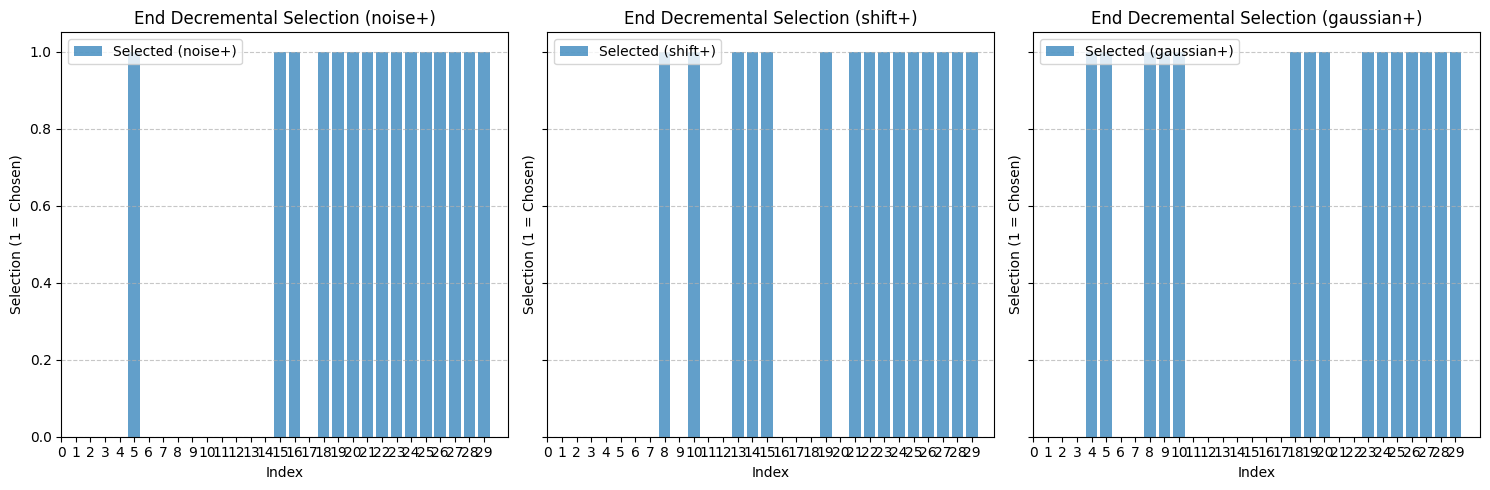

noise+: [np.int64(5), np.int64(15), np.int64(16), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29)]
shift+: [np.int64(8), np.int64(10), np.int64(13), np.int64(14), np.int64(15), np.int64(19), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29)]
gaussian+: [np.int64(4), np.int64(5), np.int64(8), np.int64(9), np.int64(10), np.int64(18), np.int64(19), np.int64(20), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29)]


In [92]:
import numpy as np
import matplotlib.pyplot as plt

def select_end_decremental_indices_v3(n, total_values=30, temperature=5.0, method="noise+"):
    """
    Chọn n giá trị duy nhất theo phân phối giảm dần từ cuối, 
    ưu tiên các index cuối của video.

    Args:
        n (int): Số lượng index cần chọn (n <= total_values).
        total_values (int): Tổng số index có thể chọn.
        temperature (float): Điều chỉnh độ sắc nét.
        method (str): Phương pháp điều chỉnh ["noise+", "shift+", "gaussian+"].

    Returns:
        selected_indices (list): Danh sách n index được chọn.
    """
    indices = np.arange(total_values)
    
    # Đảo ngược indices để tính toán từ cuối
    reversed_indices = total_values - 1 - indices
    
    if method == "noise+":
        # Tăng xác suất cho các index cuối với nhiễu nhỏ
        end_start_index = max(2, int(total_values * 0.6))  # Bắt đầu từ 60% video
        logits = np.zeros(total_values)
        logits[end_start_index:] = np.exp((reversed_indices[end_start_index:]) / temperature)
        logits += np.random.uniform(0.01, 0.05, size=total_values)
        logits[end_start_index:] *= 1.5  # Tăng thêm trọng số cho các index cuối
        
    elif method == "shift+":
        # Dịch chuyển và tăng xác suất cho các index cuối
        end_start_index = max(3, int(total_values * 0.7))  # Bắt đầu từ 70% video
        shift_factor = 3
        logits = np.zeros(total_values)
        logits[end_start_index:] = np.exp((reversed_indices[end_start_index:] + shift_factor) / temperature)
        logits += 0.01 * np.linspace(0, 1, total_values)
        logits[end_start_index:] *= 2  # Tăng gấp đôi trọng số cho các index cuối
        
    elif method == "gaussian+":
        # Gaussian với peak ở phần cuối video
        end_start_index = max(4, int(total_values * 0.8))  # Bắt đầu từ 80% video
        mean_index = total_values * 0.9  # Peak gần cuối video
        std_dev = total_values / 4  # Điều chỉnh độ rộng
        
        logits = np.zeros(total_values)
        logits[end_start_index:] = np.exp(-((indices[end_start_index:] - mean_index) ** 2) / (2 * std_dev ** 2))
        logits += 0.01  # Thêm một lượng noise nhỏ
        logits[end_start_index:] *= 2.5  # Tăng trọng số cho các index cuối
    
    else:
        raise ValueError("Phương pháp không hợp lệ. Chọn giữa 'noise+', 'shift+' hoặc 'gaussian+'.")

    # Chuẩn hóa bằng softmax
    probs = logits / np.sum(logits)
    
    # Chọn n giá trị duy nhất theo xác suất
    selected_indices = np.random.choice(indices, size=n, replace=False, p=probs)

    return sorted(selected_indices)

# Chạy thử nghiệm với các phương pháp mới
n = 15
total_values = 30
methods_v3 = ["noise+", "shift+", "gaussian+"]
selected_results_v3 = {
    method: select_end_decremental_indices_v3(
        n=n, 
        total_values=total_values, 
        temperature=10.0, 
        method=method
    ) for method in methods_v3
}

# Vẽ đồ thị
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

for ax, method in zip(axes, methods_v3):
    selected_indices = selected_results_v3[method]
    ax.bar(selected_indices, np.ones_like(selected_indices), alpha=0.7, label=f"Selected ({method})")
    ax.set_xlabel("Index")
    ax.set_ylabel("Selection (1 = Chosen)")
    ax.set_title(f"End Decremental Selection ({method})")
    ax.set_xticks(range(total_values))
    ax.grid(axis="y", linestyle="--", alpha=0.7)
    ax.legend()

plt.tight_layout()
plt.show()

# In ra các index được chọn
for method, indices in selected_results_v3.items():
    print(f"{method}: {indices}")

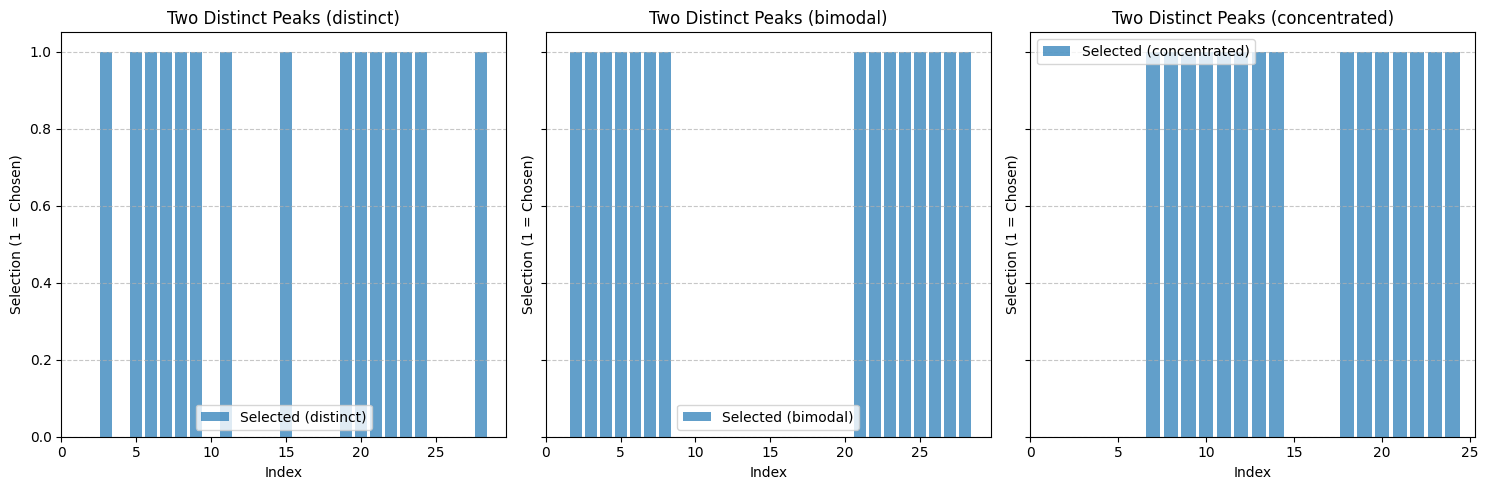

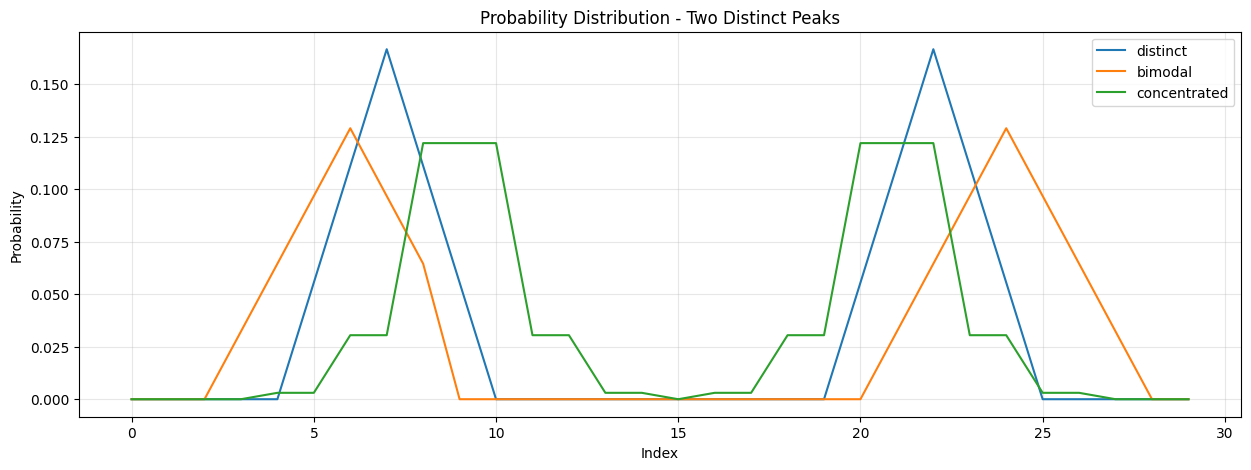

distinct: [np.int64(3), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(11), np.int64(15), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(28)]
bimodal: [np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28)]
concentrated: [np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24)]


In [110]:
import numpy as np
import matplotlib.pyplot as plt

def select_distinct_two_peaks_indices(n, total_values=30, temperature=1.0, method="distinct"):
    """
    Chọn n giá trị với phân phối hai đỉnh rõ ràng và tách biệt.

    Args:
        n (int): Số lượng index cần chọn (n <= total_values).
        total_values (int): Tổng số index có thể chọn.
        temperature (float): Điều chỉnh độ sắc nét (giá trị nhỏ = tập trung hơn).
        method (str): Phương pháp chọn lọc.

    Returns:
        selected_indices (list): Danh sách n index được chọn.
    """
    indices = np.arange(total_values)
    
    # Khởi tạo logits với giá trị rất nhỏ
    logits = np.ones(total_values) * 0.0001
    
    if method == "distinct":
        # Hai đỉnh rõ ràng, cách xa nhau
        peak1 = int(total_values * 0.25)  # Đỉnh thứ nhất ở 25%
        peak2 = int(total_values * 0.75)  # Đỉnh thứ hai ở 75%
        
        # Tạo hai đỉnh riêng biệt bằng cách gán giá trị trực tiếp
        peak1_width = 2  # Độ rộng đỉnh 1
        peak2_width = 2  # Độ rộng đỉnh 2
        
        # Gán giá trị cao cho các vị trí gần đỉnh
        for i in range(peak1 - peak1_width, peak1 + peak1_width + 1):
            if 0 <= i < total_values:
                distance = abs(i - peak1)
                logits[i] = 10.0 * (1 - distance / (peak1_width + 1))
                
        for i in range(peak2 - peak2_width, peak2 + peak2_width + 1):
            if 0 <= i < total_values:
                distance = abs(i - peak2)
                logits[i] = 10.0 * (1 - distance / (peak2_width + 1))
        
    elif method == "bimodal":
        # Hai đỉnh với phân phối bimodal rõ ràng
        peak1 = int(total_values * 0.2)  # Đỉnh thứ nhất ở 20%
        peak2 = int(total_values * 0.8)  # Đỉnh thứ hai ở 80%
        
        # Tạo giá trị cao cho các đỉnh và giảm dần
        peak1_width = 3  # Độ rộng đỉnh 1
        peak2_width = 3  # Độ rộng đỉnh 2
        
        # Tạo phân phối bimodal với đỉnh rõ ràng
        for i in range(total_values):
            dist1 = abs(i - peak1)
            dist2 = abs(i - peak2)
            
            if dist1 <= peak1_width:
                logits[i] = max(logits[i], 15.0 * (1 - dist1 / (peak1_width + 1)))
            
            if dist2 <= peak2_width:
                logits[i] = max(logits[i], 15.0 * (1 - dist2 / (peak2_width + 1)))
                
        # Giảm mạnh xác suất vùng giữa
        mid_point = (peak1 + peak2) // 2
        mid_width = (peak2 - peak1) // 3
        for i in range(mid_point - mid_width, mid_point + mid_width):
            if 0 <= i < total_values:
                logits[i] = 0.0001  # Gần như bằng 0
        
    elif method == "concentrated":
        # Hai đỉnh tập trung cao với vùng trũng giữa
        peak1 = int(total_values * 0.3)  # Đỉnh thứ nhất ở 30%
        peak2 = int(total_values * 0.7)  # Đỉnh thứ hai ở 70%
        
        # Tạo phân phối với đỉnh rất cao và vùng trũng rõ ràng
        for i in range(total_values):
            # Tính khoảng cách tới đỉnh gần nhất
            dist_to_peak = min(abs(i - peak1), abs(i - peak2))
            
            if dist_to_peak <= 1:  # Chỉ đỉnh và điểm liền kề
                logits[i] = 20.0
            elif dist_to_peak <= 3:  # Vùng gần đỉnh
                logits[i] = 5.0
            elif dist_to_peak <= 5:  # Vùng xa hơn
                logits[i] = 0.5
            else:  # Vùng xa
                logits[i] = 0.0001
    
    else:
        raise ValueError("Phương pháp không hợp lệ.")

    # Áp dụng temperature để điều chỉnh độ sắc nét
    logits = np.power(logits, 1/temperature)
    
    # Chuẩn hóa bằng softmax
    probs = logits / np.sum(logits)
    
    # Chọn n giá trị duy nhất theo xác suất
    selected_indices = np.random.choice(indices, size=n, replace=False, p=probs)

    return sorted(selected_indices)

# Chạy thử nghiệm với các phương pháp mới
n = 15
total_values = 30
methods = ["distinct", "bimodal", "concentrated"]
selected_results = {
    method: select_distinct_two_peaks_indices(
        n=n, 
        total_values=total_values, 
        temperature=1.0,  # Giảm temperature để tăng tính tập trung
        method=method
    ) for method in methods
}

# Vẽ đồ thị các index được chọn
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

for ax, method in zip(axes, methods):
    selected_indices = selected_results[method]
    ax.bar(selected_indices, np.ones_like(selected_indices), alpha=0.7, label=f"Selected ({method})")
    ax.set_xlabel("Index")
    ax.set_ylabel("Selection (1 = Chosen)")
    ax.set_title(f"Two Distinct Peaks ({method})")
    ax.set_xticks(range(0, total_values, 5))
    ax.grid(axis="y", linestyle="--", alpha=0.7)
    ax.legend()

plt.tight_layout()
plt.show()

# Vẽ phân phối xác suất
plt.figure(figsize=(15, 5))
for method in methods:
    indices = np.arange(total_values)
    
    # Tính toán lại logits để vẽ
    logits = np.ones(total_values) * 0.0001
    
    if method == "distinct":
        peak1 = int(total_values * 0.25)
        peak2 = int(total_values * 0.75)
        peak1_width = 2
        peak2_width = 2
        
        for i in range(peak1 - peak1_width, peak1 + peak1_width + 1):
            if 0 <= i < total_values:
                distance = abs(i - peak1)
                logits[i] = 10.0 * (1 - distance / (peak1_width + 1))
                
        for i in range(peak2 - peak2_width, peak2 + peak2_width + 1):
            if 0 <= i < total_values:
                distance = abs(i - peak2)
                logits[i] = 10.0 * (1 - distance / (peak2_width + 1))
                
    elif method == "bimodal":
        peak1 = int(total_values * 0.2)
        peak2 = int(total_values * 0.8)
        peak1_width = 3
        peak2_width = 3
        
        for i in range(total_values):
            dist1 = abs(i - peak1)
            dist2 = abs(i - peak2)
            
            if dist1 <= peak1_width:
                logits[i] = max(logits[i], 15.0 * (1 - dist1 / (peak1_width + 1)))
            
            if dist2 <= peak2_width:
                logits[i] = max(logits[i], 15.0 * (1 - dist2 / (peak2_width + 1)))
                
        mid_point = (peak1 + peak2) // 2
        mid_width = (peak2 - peak1) // 3
        for i in range(mid_point - mid_width, mid_point + mid_width):
            if 0 <= i < total_values:
                logits[i] = 0.0001
                
    elif method == "concentrated":
        peak1 = int(total_values * 0.3)
        peak2 = int(total_values * 0.7)
        
        for i in range(total_values):
            dist_to_peak = min(abs(i - peak1), abs(i - peak2))
            
            if dist_to_peak <= 1:
                logits[i] = 20.0
            elif dist_to_peak <= 3:
                logits[i] = 5.0
            elif dist_to_peak <= 5:
                logits[i] = 0.5
            else:
                logits[i] = 0.0001
    
    probs = logits / np.sum(logits)
    plt.plot(indices, probs, label=method)

plt.xlabel("Index")
plt.ylabel("Probability")
plt.title("Probability Distribution - Two Distinct Peaks")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# In ra các index được chọn
for method, indices in selected_results.items():
    print(f"{method}: {indices}")

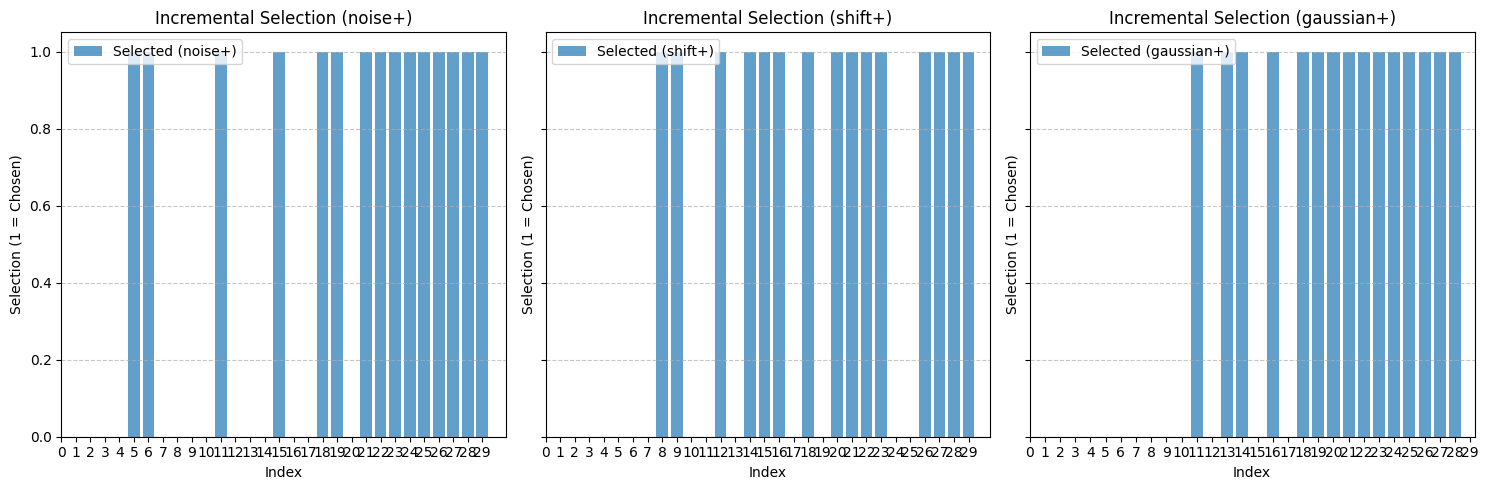

noise+: [np.int64(5), np.int64(6), np.int64(11), np.int64(15), np.int64(18), np.int64(19), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29)]
shift+: [np.int64(8), np.int64(9), np.int64(12), np.int64(14), np.int64(15), np.int64(16), np.int64(18), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(26), np.int64(27), np.int64(28), np.int64(29)]
gaussian+: [np.int64(11), np.int64(13), np.int64(14), np.int64(16), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28)]


In [154]:
import numpy as np
import matplotlib.pyplot as plt

def select_incremental_indices_v3(n, total_values=30, temperature=5.0, method="noise+"):
    """
    Chọn n giá trị duy nhất theo phân phối tăng dần (incremental) 
    với cải tiến để tránh luôn chọn các index đầu tiên.

    Args:
        n (int): Số lượng index cần chọn (n <= total_values).
        total_values (int): Tổng số index có thể chọn.
        temperature (float): Điều chỉnh độ sắc nét.
        method (str): Phương pháp điều chỉnh ["noise+", "shift+", "gaussian+"].

    Returns:
        selected_indices (list): Danh sách n index được chọn.
    """
    indices = np.arange(total_values)
    
    if method == "noise+":
        # Tăng nhiễu và giảm xác suất cho các index đầu
        start_index = max(2, int(total_values * 0.1))  # Bắt đầu từ index thứ 2 hoặc 10%
        logits = np.zeros(total_values)
        logits[start_index:] = np.exp((indices[start_index:] - start_index) / temperature)
        logits += np.random.uniform(0.01, 0.05, size=total_values)
        
    elif method == "shift+":
        # Dịch chuyển và giảm xác suất cho các index đầu
        start_index = max(3, int(total_values * 0.15))  # Bắt đầu từ index thứ 3 hoặc 15%
        shift_factor = 3
        logits = np.zeros(total_values)
        logits[start_index:] = np.exp((indices[start_index:] - start_index + shift_factor) / temperature)
        logits += 0.01 * np.linspace(0, 1, total_values)
        
    elif method == "gaussian+":
        # Gaussian với peak ở phần sau và giảm xác suất cho các index đầu
        start_index = max(4, int(total_values * 0.2))  # Bắt đầu từ index thứ 4 hoặc 20%
        mean_index = total_values * 0.7  # Peak ở 70% vị trí
        std_dev = total_values / 4  # Điều chỉnh độ rộng
        
        logits = np.zeros(total_values)
        logits[start_index:] = np.exp(-((indices[start_index:] - mean_index) ** 2) / (2 * std_dev ** 2))
        logits += 0.01  # Thêm một lượng noise nhỏ
    
    else:
        raise ValueError("Phương pháp không hợp lệ. Chọn giữa 'noise+', 'shift+' hoặc 'gaussian+'.")

    # Chuẩn hóa bằng softmax
    probs = logits / np.sum(logits)
    
    # Chọn n giá trị duy nhất theo xác suất
    selected_indices = np.random.choice(indices, size=n, replace=False, p=probs)

    return sorted(selected_indices)

# Chạy thử nghiệm với các phương pháp mới
n = 15
total_values = 30
methods_v3 = ["noise+", "shift+", "gaussian+"]
selected_results_v3 = {
    method: select_incremental_indices_v3(
        n=n, 
        total_values=total_values, 
        temperature=10.0, 
        method=method
    ) for method in methods_v3
}

# Vẽ đồ thị
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

for ax, method in zip(axes, methods_v3):
    selected_indices = selected_results_v3[method]
    ax.bar(selected_indices, np.ones_like(selected_indices), alpha=0.7, label=f"Selected ({method})")
    ax.set_xlabel("Index")
    ax.set_ylabel("Selection (1 = Chosen)")
    ax.set_title(f"Incremental Selection ({method})")
    ax.set_xticks(range(total_values))
    ax.grid(axis="y", linestyle="--", alpha=0.7)
    ax.legend()

plt.tight_layout()
plt.show()

# In ra các index được chọn
for method, indices in selected_results_v3.items():
    print(f"{method}: {indices}")